In [ ]:
# ------------------ 1. IMPORT LIBRARIES ------------------
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report

# Models
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# ------------------ 2. LOAD AND MERGE DATA ------------------
def load_data():
    connectome = pd.read_csv('/content/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
    quantitative = pd.read_excel('/content/TRAIN_QUANTITATIVE_METADATA_new.xlsx')
    categorical = pd.read_excel('/content/TRAIN_CATEGORICAL_METADATA_new.xlsx')
    solutions = pd.read_excel('/content/TRAINING_SOLUTIONS.xlsx')

    data = connectome.merge(quantitative, on='participant_id')
    data = data.merge(categorical, on='participant_id')
    data = data.merge(solutions, on='participant_id')
    return data

# ------------------ 3. CLEAN AND PREPARE DATA ------------------
def preprocess_data(data, target):
    X = data.drop(columns=['participant_id', 'Sex_F', 'ADHD_Outcome'])
    y = data[target]

    # Impute missing values
    X_imputed = SimpleImputer(strategy='median').fit_transform(X)

    # Select top 300 features
    X_selected = SelectKBest(score_func=f_classif, k=300).fit_transform(X_imputed, y)

    # Train/validation split
    return train_test_split(X_selected, y, test_size=0.2, random_state=42)

# ------------------ 4. SEX MODEL: VOTING ENSEMBLE ------------------
def train_sex_model(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42
    )

    xgb = XGBClassifier(
        eval_metric='logloss',
        learning_rate=0.1,
        max_depth=6,
        n_estimators=100,
        random_state=42
    )

    lr = LogisticRegression(max_iter=1000, class_weight='balanced')

    model = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lr', lr)],
        voting='soft'
    )

    model.fit(X_resampled, y_resampled)
    return model

# ------------------ 5. ADHD MODEL: XGBOOST ------------------
def train_adhd_model(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    xgb = XGBClassifier(
        eval_metric='logloss',
        learning_rate=0.1,
        max_depth=6,
        n_estimators=100,
        random_state=42
    )

    xgb.fit(X_resampled, y_resampled)
    return xgb

# ------------------ 6. RUN ALL ------------------
if __name__ == "__main__":
    data = load_data()
    print(f"Final merged shape: {data.shape}")

    # ----- SEX MODEL -----
    X_sex_train, X_sex_val, y_sex_train, y_sex_val = preprocess_data(data, target='Sex_F')
    print(f"\nSEX: Before SMOTE: {y_sex_train.value_counts().to_dict()}")
    sex_model = train_sex_model(X_sex_train, y_sex_train)
    sex_preds = sex_model.predict(X_sex_val)
    print("\n Validation Report for SEX_F (Voting Ensemble):")
    print(classification_report(y_sex_val, sex_preds))

    # ----- ADHD MODEL -----
    X_adhd_train, X_adhd_val, y_adhd_train, y_adhd_val = preprocess_data(data, target='ADHD_Outcome')
    print(f"\nADHD: Before SMOTE: {y_adhd_train.value_counts().to_dict()}")
    adhd_model = train_adhd_model(X_adhd_train, y_adhd_train)
    adhd_preds = adhd_model.predict(X_adhd_val)
    print("\n Validation Report for ADHD_Outcome (SMOTE + XGBoost):")
    print(classification_report(y_adhd_val, adhd_preds))


Final merged shape: (1213, 19930)

SEX: Before SMOTE: {0: 635, 1: 335}

 Validation Report for SEX_F (Voting Ensemble):
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       162
           1       0.73      0.59      0.65        81

    accuracy                           0.79       243
   macro avg       0.77      0.74      0.75       243
weighted avg       0.78      0.79      0.78       243


ADHD: Before SMOTE: {1: 675, 0: 295}

 Validation Report for ADHD_Outcome (SMOTE + XGBoost):
              precision    recall  f1-score   support

           0       0.75      0.66      0.70        87
           1       0.82      0.88      0.85       156

    accuracy                           0.80       243
   macro avg       0.79      0.77      0.77       243
weighted avg       0.80      0.80      0.79       243



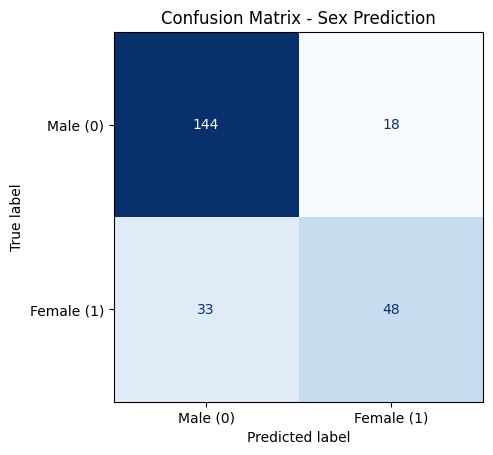

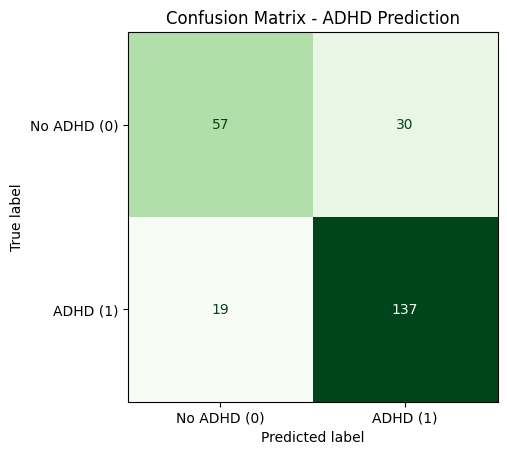

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# SEX model confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_sex_val, sex_preds,
    display_labels=["Male (0)", "Female (1)"],
    cmap="Blues",
    colorbar=False
)
plt.title("Confusion Matrix - Sex Prediction")
plt.show()

# ADHD model confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_adhd_val, adhd_preds,
    display_labels=["No ADHD (0)", "ADHD (1)"],
    cmap="Greens",
    colorbar=False
)
plt.title("Confusion Matrix - ADHD Prediction")
plt.show()


In [ ]:
# ------------------ 1. IMPORT LIBRARIES ------------------
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, models, callbacks

# ------------------ 2. LOAD & MERGE DATA ------------------
# Adjust file paths as necessary
df_conn = pd.read_csv('/content/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
df_quant = pd.read_excel('/content/TRAIN_QUANTITATIVE_METADATA_new.xlsx')
df_cat = pd.read_excel('/content/TRAIN_CATEGORICAL_METADATA_new.xlsx')
df_sol = pd.read_excel('/content/TRAINING_SOLUTIONS.xlsx')

df = df_conn.merge(df_quant, on='participant_id') \
          .merge(df_cat, on='participant_id') \
          .merge(df_sol, on='participant_id')

# ------------------ 3. EXTRACT FEATURES & LABELS ------------------
# Connectivity features
conn_cols = [c for c in df_conn.columns if c != 'participant_id']
num_conn = len(conn_cols)
# Solve n*(n-1)/2 = num_conn for n
n = int((1 + np.sqrt(1 + 8 * num_conn)) // 2)
flat = df[conn_cols].values  # shape (N, num_conn)

# Reconstruct symmetric matrices
X_conn = np.zeros((flat.shape[0], n, n), dtype=np.float32)
i, j = np.triu_indices(n, k=1)
X_conn[:, i, j] = flat
X_conn[:, j, i] = flat
X_conn = X_conn[..., np.newaxis]  # shape (N, n, n, 1)

# Metadata features
meta_cols = [c for c in df.columns if c not in ['participant_id','Sex_F','ADHD_Outcome'] + conn_cols]
X_meta = df[meta_cols].values

# Labels
y_sex  = df['Sex_F'].values
y_adhd = df['ADHD_Outcome'].values

# ------------------ 4. TRAIN/VALIDATION SPLIT ------------------
Xc_tr, Xc_val, Xm_tr, Xm_val, y1_tr, y1_val, y2_tr, y2_val = train_test_split(
    X_conn, X_meta, y_sex, y_adhd,
    test_size=0.2, stratify=y_adhd, random_state=42
)

# ------------------ 5. IMPUTE & SCALE METADATA ------------------
meta_imputer = SimpleImputer(strategy='median')
Xm_tr_imp = meta_imputer.fit_transform(Xm_tr)
Xm_val_imp = meta_imputer.transform(Xm_val)

meta_scaler = StandardScaler()
Xm_tr_imp = meta_scaler.fit_transform(Xm_tr_imp)
Xm_val_imp = meta_scaler.transform(Xm_val_imp)

# ------------------ 6. BALANCE TRAINING DATA WITH SMOTE ------------------
# Use SMOTE on integer indices to align both branches
idx = np.arange(len(Xm_tr_imp)).reshape(-1, 1)
sm = SMOTE(random_state=42)
idx_res, y2_res = sm.fit_resample(idx, y2_tr)
idx_res = idx_res.flatten()

# Resampled connectivity and metadata
Xc_res = Xc_tr[idx_res]
Xm_res = Xm_tr_imp[idx_res]
# Resample sex labels for multi-task
y1_res = y1_tr[idx_res]

# ------------------ 7. BUILD DUAL-BRANCH CNN MODEL ------------------
# Connectivity branch
inp_conn = layers.Input(shape=(n, n, 1), name='connectome')
c = layers.Conv2D(32, 3, activation='relu', padding='same')(inp_conn)
c = layers.MaxPool2D()(c)
c = layers.Conv2D(64, 3, activation='relu', padding='same')(c)
c = layers.MaxPool2D()(c)
c = layers.Flatten()(c)
c = layers.Dense(128, activation='relu')(c)

# Metadata branch
inp_meta = layers.Input(shape=(Xm_res.shape[1],), name='metadata')
m = layers.Dense(128, activation='relu')(inp_meta)
m = layers.Dense(64, activation='relu')(m)

# Combine branches
combined = layers.concatenate([c, m])
x = layers.Dense(128, activation='relu')(combined)
x = layers.Dropout(0.3)(x)

# Two output heads
out_sex  = layers.Dense(1, activation='sigmoid', name='sex')(x)
out_adhd = layers.Dense(1, activation='sigmoid', name='adhd')(x)

model = models.Model(inputs=[inp_conn, inp_meta], outputs=[out_sex, out_adhd])

# ------------------ 8. COMPILE MODEL WITH WEIGHTED LOSS ------------------
model.compile(
    optimizer='adam',
    loss={'sex':'binary_crossentropy', 'adhd':'binary_crossentropy'},
    loss_weights={'sex':1.0, 'adhd':2.0},
    metrics={'sex':'accuracy', 'adhd':'accuracy'}  # specify a metric per output
)

# ------------------ 9. TRAIN MODEL ------------------
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    {'connectome': Xc_res, 'metadata': Xm_res},
    {'sex': y1_res, 'adhd': y2_res},
    validation_data=(
        {'connectome': Xc_val, 'metadata': Xm_val_imp},
        {'sex': y1_val, 'adhd': y2_val}
    ),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

# ------------------ 10. EVALUATE MODEL ------------------
results = model.evaluate(
    {'connectome': Xc_val, 'metadata': Xm_val_imp},
    {'sex': y1_val, 'adhd': y2_val},
    verbose=0
)
print(f"\n▶ Validation Sex Accuracy:  {results[3]:.3f}")
print(f"▶ Validation ADHD Accuracy: {results[4]:.3f}")


Epoch 1/100
42/42 - 98s - 2s/step - adhd_accuracy: 0.5639 - adhd_loss: 0.8334 - loss: 2.4025 - sex_accuracy: 0.6286 - sex_loss: 0.7299 - val_adhd_accuracy: 0.7078 - val_adhd_loss: 0.6013 - val_loss: 1.8318 - val_sex_accuracy: 0.6872 - val_sex_loss: 0.6295
Epoch 2/100
42/42 - 138s - 3s/step - adhd_accuracy: 0.6812 - adhd_loss: 0.5975 - loss: 1.8240 - sex_accuracy: 0.6556 - sex_loss: 0.6253 - val_adhd_accuracy: 0.6708 - val_adhd_loss: 0.5830 - val_loss: 1.7629 - val_sex_accuracy: 0.6872 - val_sex_loss: 0.5932
Epoch 3/100
42/42 - 144s - 3s/step - adhd_accuracy: 0.7015 - adhd_loss: 0.5664 - loss: 1.7331 - sex_accuracy: 0.6842 - sex_loss: 0.6000 - val_adhd_accuracy: 0.7325 - val_adhd_loss: 0.5443 - val_loss: 1.6808 - val_sex_accuracy: 0.7037 - val_sex_loss: 0.5895
Epoch 4/100
42/42 - 91s - 2s/step - adhd_accuracy: 0.7346 - adhd_loss: 0.5492 - loss: 1.6822 - sex_accuracy: 0.6887 - sex_loss: 0.5852 - val_adhd_accuracy: 0.6790 - val_adhd_loss: 0.5853 - val_loss: 1.7805 - val_sex_accuracy: 0.70

In [ ]:
# ------------------ 1. IMPORT LIBRARIES ------------------
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from tensorflow.keras import Model, layers
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# ------------------ 2. LOAD AND MERGE DATA ------------------
df_conn = pd.read_csv('/content/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
df_quant = pd.read_excel('/content/TRAIN_QUANTITATIVE_METADATA_new.xlsx')
df_cat = pd.read_excel('/content/TRAIN_CATEGORICAL_METADATA_new.xlsx')
df_sol = pd.read_excel('/content/TRAINING_SOLUTIONS.xlsx')

df = df_conn.merge(df_quant, on='participant_id') \
          .merge(df_cat, on='participant_id') \
          .merge(df_sol, on='participant_id')

# ------------------ 3. COMPUTE GRAPH METRICS ------------------
conn_cols = [c for c in df_conn.columns if c!='participant_id']
# Build graph metrics: degree centrality and clustering coefficient
graph_metrics = []
for _, row in df_conn.iterrows():
    edges = row[conn_cols].values
n = int((1 + np.sqrt(1+8*len(conn_cols)))//2)
# indices of upper triangle
iu = np.triu_indices(n, k=1)
for idx, row in df_conn.iterrows():
    flat = row[conn_cols].values
    mat = np.zeros((n,n))
    mat[iu] = flat
    mat[(iu[1], iu[0])] = flat
    G = nx.from_numpy_array(mat)
    deg = np.mean(list(nx.degree_centrality(G).values()))
    clust = np.mean(list(nx.clustering(G).values()))
    graph_metrics.append([deg, clust])

graph_metrics = np.array(graph_metrics)

# ------------------ 4. AUTOENCODER EMBEDDINGS ------------------
# Prepare flat connectome data
X_flat = df_conn[conn_cols].values
# Impute missing if any
imp = SimpleImputer(strategy='median')
X_flat_imp = imp.fit_transform(X_flat)
# Scale
sc = StandardScaler()
X_flat_scaled = sc.fit_transform(X_flat_imp)

# Build autoencoder
input_dim = X_flat_scaled.shape[1]
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(128, activation='relu')(input_layer)
encoded = layers.Dense(50, activation='relu', name='bottleneck')(encoded)
decoded = layers.Dense(128, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

ae = Model(inputs=input_layer, outputs=decoded)
ae.compile(optimizer='adam', loss='mse')
# Train autoencoder
ae.fit(X_flat_scaled, X_flat_scaled, epochs=50, batch_size=32, verbose=0)
# Extract embeddings
encoder = Model(inputs=ae.input, outputs=ae.get_layer('bottleneck').output)
embeddings = encoder.predict(X_flat_scaled)

# ------------------ 5. COMBINE FEATURES ------------------
# Metadata features
meta_cols = [c for c in df.columns if c not in ['participant_id','Sex_F','ADHD_Outcome']+conn_cols]
X_meta = df[meta_cols].values
# Impute and scale metadata
X_meta_imp = imp.transform(X_meta)
X_meta_scaled = sc.transform(X_meta_imp)

# Final feature matrix: [embeddings, graph_metrics, metadata]
X_final = np.hstack([embeddings, graph_metrics, X_meta_scaled])
y_sex = df['Sex_F'].values
y_adhd = df['ADHD_Outcome'].values

# ------------------ 6. TRAIN/VALIDATE MODELS ------------------
# Split
X_train, X_val, y_sex_train, y_sex_val, y_adhd_train, y_adhd_val = train_test_split(
    X_final, y_sex, y_adhd, test_size=0.2, stratify=y_adhd, random_state=42)

# SMOTE for ADHD
sm = SMOTE(random_state=42)
X_train_res, y_adhd_res = sm.fit_resample(X_train, y_adhd_train)
# For Sex, use same X_train_res and y_sex_train_res
_, y_sex_res = sm.fit_resample(X_train, y_sex_train)

# Define Voting ensemble
def build_voting():
    rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
    lr = LogisticRegression(max_iter=2000, class_weight='balanced')
    return VotingClassifier(estimators=[('rf',rf),('xgb',xgb),('lr',lr)], voting='soft')

# Train for Sex_F
top_sex = build_voting()
top_sex.fit(X_train_res, y_sex_res)
sex_preds = top_sex.predict(X_val)
print("\n=== Sex_F Validation ===")
print(classification_report(y_sex_val, sex_preds))

# Train for ADHD
top_adhd = build_voting()
top_adhd.fit(X_train_res, y_adhd_res)
adhd_preds = top_adhd.predict(X_val)
print("\n=== ADHD_Outcome Validation ===")
print(classification_report(y_adhd_val, adhd_preds))


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


ValueError: X has 27 features, but SimpleImputer is expecting 19900 features as input.

**Tanyas code: XGBoost model for ADHD classification**

In [ ]:
# installing necessary library
!pip install xgboost

from xgboost import XGBClassifier

In [ ]:
# using the variable scale_pos_weight to deal with class imablance and dividing into positive and negative class
adhd_pos_class = sum(y_adhd_train)
adhd_neg_class = len(y_adhd_train) - adhd_pos_class
adhd_balance_var = adhd_neg_class / adhd_pos_class

In [ ]:
# 1) IMPORT LIBRARIES
import numpy as np
import pandas as pd
import networkx as nx

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
from tensorflow.keras import layers, Model, Input

# 2) FILE PATHS (Colab `/content`)
TRAIN_CONN = '/content/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv'
TRAIN_QUAN = '/content/TRAIN_QUANTITATIVE_METADATA_new.xlsx'
TRAIN_CAT  = '/content/TRAIN_CATEGORICAL_METADATA_new.xlsx'
TRAIN_SOL  = '/content/TRAINING_SOLUTIONS.xlsx'

TEST_CONN  = '/content/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv'
TEST_QUAN  = '/content/TEST_QUANTITATIVE_METADATA.xlsx'
TEST_CAT   = '/content/TEST_CATEGORICAL.xlsx'

# 3) LOAD & MERGE TRAINING DATA
df_conn = pd.read_csv(TRAIN_CONN)
df_quan = pd.read_excel(TRAIN_QUAN)
df_cat  = pd.read_excel(TRAIN_CAT)
df_sol  = pd.read_excel(TRAIN_SOL)

train = (df_conn
         .merge(df_quan, on='participant_id')
         .merge(df_cat, on='participant_id')
         .merge(df_sol, on='participant_id'))

# 4) EXTRACT FEATURES & LABELS
conn_cols = [c for c in df_conn.columns if c!='participant_id']
meta_cols = [c for c in train.columns
             if c not in ['participant_id','Sex_F','ADHD_Outcome'] + conn_cols]

y_sex  = train['Sex_F'].values
y_adhd = train['ADHD_Outcome'].values
X_conn = train[conn_cols].values
X_meta = train[meta_cols].values

# 5) GRAPH METRICS
n = int((1 + np.sqrt(1 + 8*len(conn_cols)))//2)
iu = np.triu_indices(n, k=1)
graph_feats = []
for row in X_conn:
    M = np.zeros((n, n))
    M[iu] = row
    M[(iu[1], iu[0])] = row
    G = nx.from_numpy_array(M)
    graph_feats.append([
        np.mean(list(nx.degree_centrality(G).values())),
        np.mean(list(nx.clustering(G).values()))
    ])
X_graph = np.array(graph_feats)

# 6) AUTOENCODER EMBEDDING (50-dim)
inp = Input(shape=(X_conn.shape[1],))
z = layers.Dense(128, activation='relu')(inp)
z = layers.Dense(50, activation='relu', name='bottleneck')(z)
d = layers.Dense(128, activation='relu')(z)
out = layers.Dense(X_conn.shape[1], activation='linear')(d)
ae = Model(inp, out)
ae.compile('adam','mse')
ae.fit(X_conn, X_conn, epochs=20, batch_size=64, verbose=0)
encoder = Model(inp, ae.get_layer('bottleneck').output)
X_ae = encoder.predict(X_conn)

# 7) PREPROCESS META & PCA(CONN)
imp_meta = SimpleImputer(strategy='median')
sc_meta  = StandardScaler()
X_meta_p = sc_meta.fit_transform(imp_meta.fit_transform(X_meta))

imp_conn = SimpleImputer(strategy='median')
sc_conn  = StandardScaler()
pca_conn = PCA(n_components=100, random_state=42)
X_conn_p = pca_conn.fit_transform(
    sc_conn.fit_transform(imp_conn.fit_transform(X_conn))
)

# 8) COMBINE ALL FEATURES
X_all = np.hstack([X_conn_p, X_meta_p, X_graph, X_ae])

# 9) STRATIFIED K-FOLD + SMOTE + STACKING + CALIBRATION
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_sex  = np.zeros(len(X_all))
oof_adhd = np.zeros(len(X_all))

estimators = [
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                          n_estimators=200, max_depth=6, learning_rate=0.05, random_state=42)),
    ('lgb', LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.05,
                           class_weight='balanced', random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500,
                           early_stopping=True, random_state=42)),
    ('lr',  LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42))
]
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=XGBClassifier(n_estimators=100, random_state=42),
    cv=3, n_jobs=-1
)

for tr_idx, val_idx in skf.split(X_all, y_adhd):
    Xtr, Xv = X_all[tr_idx], X_all[val_idx]
    ys_tr, ya_tr = y_sex[tr_idx], y_adhd[tr_idx]
    # SMOTE balances
    Xs_tr, ys_s = SMOTE(random_state=42).fit_resample(Xtr, ys_tr)
    Xa_tr, ya_s = SMOTE(random_state=42).fit_resample(Xtr, ya_tr)

    # Sex head
    stack.fit(Xs_tr, ys_s)
    cal_s = CalibratedClassifierCV(stack, cv='prefit').fit(Xs_tr, ys_s)
    oof_sex[val_idx] = cal_s.predict_proba(Xv)[:,1]

    # ADHD head
    stack.fit(Xa_tr, ya_s)
    cal_a = CalibratedClassifierCV(stack, cv='prefit').fit(Xa_tr, ya_s)
    oof_adhd[val_idx] = cal_a.predict_proba(Xv)[:,1]

print("OOF Sex_F:\n", classification_report(y_sex, (oof_sex>0.5).astype(int)))
print("OOF ADHD:\n", classification_report(y_adhd, (oof_adhd>0.5).astype(int)))

# 10) FINAL TRAIN & TEST PREDICTION
Xf_s, yf_s = SMOTE(random_state=42).fit_resample(X_all, y_sex)
stack.fit(Xf_s, yf_s)
cal_s_full = CalibratedClassifierCV(stack, cv='prefit').fit(Xf_s, yf_s)

Xf_a, yf_a = SMOTE(random_state=42).fit_resample(X_all, y_adhd)
stack.fit(Xf_a, yf_a)
cal_a_full = CalibratedClassifierCV(stack, cv='prefit').fit(Xf_a, yf_a)

# load & preprocess test
df_conn_t = pd.read_csv(TEST_CONN)
df_quan_t = pd.read_excel(TEST_QUAN)
df_cat_t  = pd.read_excel(TEST_CAT)
test = df_conn_t.merge(df_quan_t, on='participant_id').merge(df_cat_t, on='participant_id')

Xc_t = pca_conn.transform(sc_conn.transform(imp_conn.transform(test[conn_cols].values)))
Xm_t = sc_meta.transform(imp_meta.transform(test[meta_cols].values))

graph_t = []
for row in test[conn_cols].values:
    M = np.zeros((n,n))
    M[iu] = row
    M[(iu[1],iu[0])] = row
    G = nx.from_numpy_array(M)
    graph_t.append([np.mean(list(nx.degree_centrality(G).values())),
                    np.mean(list(nx.clustering(G).values()))])
graph_t = np.array(graph_t)
ae_t = encoder.predict(test[conn_cols].values)

X_test = np.hstack([Xc_t, Xm_t, graph_t, ae_t])

test['Sex_F']        = cal_s_full.predict_proba(X_test)[:,1]
test['ADHD_Outcome'] = cal_a_full.predict_proba(X_test)[:,1]

submission = test[['participant_id','ADHD_Outcome','Sex_F']]
submission.to_csv('submission.csv', index=False)
print("→ submission.csv created!")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif

# 1. LOAD DATA
conn = pd.read_csv("/content/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
quan = pd.read_excel("/content/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
cat = pd.read_excel("/content/TRAIN_CATEGORICAL_METADATA_new.xlsx")
sol = pd.read_excel("/content/TRAINING_SOLUTIONS.xlsx")

data = conn.merge(quan, on="participant_id").merge(cat, on="participant_id").merge(sol, on="participant_id")

# 2. PREPARE DATA
X = data.drop(columns=["participant_id", "Sex_F", "ADHD_Outcome"])
y_sex = data["Sex_F"]
y_adhd = data["ADHD_Outcome"]

# Impute, scale, and select features
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

selector_sex = SelectKBest(score_func=f_classif, k=300).fit(X_scaled, y_sex)
selector_adhd = SelectKBest(score_func=f_classif, k=300).fit(X_scaled, y_adhd)
X_sex = selector_sex.transform(X_scaled)
X_adhd = selector_adhd.transform(X_scaled)

# 3. SPLIT & BALANCE SEX DATA
X_train_sex, X_val_sex, y_train_sex, y_val_sex = train_test_split(X_sex, y_sex, test_size=0.2, random_state=42)
sm_sex = SMOTE(random_state=42)
X_train_sex_bal, y_train_sex_bal = sm_sex.fit_resample(X_train_sex, y_train_sex)

# 4. SPLIT & BALANCE ADHD DATA
X_train_adhd, X_val_adhd, y_train_adhd, y_val_adhd = train_test_split(X_adhd, y_adhd, test_size=0.2, random_state=42)
sm_adhd = SMOTE(random_state=42)
X_train_adhd_bal, y_train_adhd_bal = sm_adhd.fit_resample(X_train_adhd, y_train_adhd)

# 5. DEFINE BASE MODELS
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
xgb = XGBClassifier(eval_metric='logloss', learning_rate=0.1, max_depth=6, n_estimators=100, random_state=42, use_label_encoder=False)
lgb = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
lr = LogisticRegression(max_iter=1000)

# 6. STACKED MODEL FOR SEX_F
voting_sex = VotingClassifier(estimators=[
    ('rf', rf), ('xgb', xgb), ('lgb', lgb), ('lr', lr)
], voting='soft')
voting_sex.fit(X_train_sex_bal, y_train_sex_bal)
pred_sex = voting_sex.predict(X_val_sex)
acc_sex = accuracy_score(y_val_sex, pred_sex)
report_sex = classification_report(y_val_sex, pred_sex)

# 7. STACKED MODEL FOR ADHD
voting_adhd = VotingClassifier(estimators=[
    ('rf', rf), ('xgb', xgb), ('lgb', lgb), ('lr', lr)
], voting='soft')
voting_adhd.fit(X_train_adhd_bal, y_train_adhd_bal)
pred_adhd = voting_adhd.predict(X_val_adhd)
acc_adhd = accuracy_score(y_val_adhd, pred_adhd)
report_adhd = classification_report(y_val_adhd, pred_adhd)

(acc_sex, acc_adhd, report_sex, report_adhd)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:35:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 635, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75886
[LightGBM] [Info] Number of data points in the train set: 1270, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:35:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 675, number of negative: 675
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75576
[LightGBM] [Info] Number of data points in the train set: 1350, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(0.7901234567901234,
 0.8395061728395061,
 '              precision    recall  f1-score   support\n\n           0       0.81      0.89      0.85       162\n           1       0.73      0.59      0.65        81\n\n    accuracy                           0.79       243\n   macro avg       0.77      0.74      0.75       243\nweighted avg       0.78      0.79      0.78       243\n',
 '              precision    recall  f1-score   support\n\n           0       0.82      0.71      0.76        87\n           1       0.85      0.91      0.88       156\n\n    accuracy                           0.84       243\n   macro avg       0.83      0.81      0.82       243\nweighted avg       0.84      0.84      0.84       243\n')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from google.colab import files

# --- Load test data ---
test_conn = pd.read_csv('/content/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')
test_quan = pd.read_excel('/content/TEST_QUANTITATIVE_METADATA.xlsx')
test_cat = pd.read_excel('/content/TEST_CATEGORICAL.xlsx')

# --- Merge test data ---
test_df = test_conn.merge(test_quan, on='participant_id').merge(test_cat, on='participant_id')

# --- Prepare test features ---
participant_ids = test_df['participant_id']
X_test = test_df.drop(columns=['participant_id'])

# --- Preprocess using training transformers ---
X_test_imp = imputer.transform(X_test)                # Impute missing values (trained)
X_test_scaled = scaler.transform(X_test_imp)          # Standardize (trained)
X_test_selected = selector.transform(X_test_scaled)   # Feature selection (trained)

# --- Make predictions ---
sex_preds = sex_model.predict(X_test_selected)
adhd_preds = adhd_model.predict(X_test_selected)

# --- Save predictions to CSV ---
submission = pd.DataFrame({
    'participant_id': participant_ids,
    'Sex_F': np.round(sex_preds).astype(int),
    'ADHD_Outcome': np.round(adhd_preds).astype(int)
})

submission.to_csv('submission.csv', index=False)
print("✅ Saved submission as 'submission.csv'")

# --- Auto-download the file in Colab ---
files.download('submission.csv')


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
# 🛠 Install libraries if missing
!pip install -q lightgbm xgboost catboost imbalanced-learn

# 📚 Imports
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 1. LOAD DATA
conn = pd.read_csv("/content/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
quan = pd.read_excel("/content/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
cat = pd.read_excel("/content/TRAIN_CATEGORICAL_METADATA_new.xlsx")
sol = pd.read_excel("/content/TRAINING_SOLUTIONS.xlsx")

data = conn.merge(quan, on="participant_id").merge(cat, on="participant_id").merge(sol, on="participant_id")

# 2. PREPARE DATA
X = data.drop(columns=["participant_id", "Sex_F", "ADHD_Outcome"])
y_sex = data["Sex_F"]
y_adhd = data["ADHD_Outcome"]

# Preprocessing
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Feature selection separately
selector_sex = SelectKBest(score_func=f_classif, k=300).fit(X_scaled, y_sex)
selector_adhd = SelectKBest(score_func=f_classif, k=300).fit(X_scaled, y_adhd)

X_sex = selector_sex.transform(X_scaled)
X_adhd = selector_adhd.transform(X_scaled)

# 3. SPLIT & BALANCE SEX DATA
X_train_sex, X_val_sex, y_train_sex, y_val_sex = train_test_split(X_sex, y_sex, test_size=0.2, random_state=42)
sm_sex = SMOTE(random_state=42)
X_train_sex_bal, y_train_sex_bal = sm_sex.fit_resample(X_train_sex, y_train_sex)

# 4. SPLIT & BALANCE ADHD DATA
X_train_adhd, X_val_adhd, y_train_adhd, y_val_adhd = train_test_split(X_adhd, y_adhd, test_size=0.2, random_state=42)
sm_adhd = SMOTE(random_state=42)
X_train_adhd_bal, y_train_adhd_bal = sm_adhd.fit_resample(X_train_adhd, y_train_adhd)

# 5. DEFINE BASE MODELS (Tuned)
xgb_params = {
    'n_estimators': 150,
    'learning_rate': 0.05,
    'max_depth': 6,
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42
}

lgbm_params = {
    'n_estimators': 150,
    'learning_rate': 0.05,
    'max_depth': 6,
    'random_state': 42
}

cat_params = {
    'iterations': 150,
    'learning_rate': 0.05,
    'depth': 6,
    'verbose': 0,
    'random_seed': 42
}

xgb_sex = XGBClassifier(**xgb_params)
lgb_sex = LGBMClassifier(**lgbm_params)
cat_sex = CatBoostClassifier(**cat_params)

xgb_adhd = XGBClassifier(**xgb_params)
lgb_adhd = LGBMClassifier(**lgbm_params)
cat_adhd = CatBoostClassifier(**cat_params)

# 6. ENSEMBLE: Voting Classifier
voting_sex = VotingClassifier(estimators=[
    ('xgb', xgb_sex),
    ('lgb', lgb_sex),
    ('cat', cat_sex)
], voting='soft')

voting_adhd = VotingClassifier(estimators=[
    ('xgb', xgb_adhd),
    ('lgb', lgb_adhd),
    ('cat', cat_adhd)
], voting='soft')

# 7. TRAIN MODELS
voting_sex.fit(X_train_sex_bal, y_train_sex_bal)
voting_adhd.fit(X_train_adhd_bal, y_train_adhd_bal)

# 8. VALIDATION RESULTS
pred_sex = voting_sex.predict(X_val_sex)
pred_adhd = voting_adhd.predict(X_val_adhd)

acc_sex = accuracy_score(y_val_sex, pred_sex)
acc_adhd = accuracy_score(y_val_adhd, pred_adhd)

print("\n--- SEX_F Validation Results ---")
print(f"Accuracy: {acc_sex:.4f}")
print(classification_report(y_val_sex, pred_sex))

print("\n--- ADHD_Outcome Validation Results ---")
print(f"Accuracy: {acc_adhd:.4f}")
print(classification_report(y_val_adhd, pred_adhd))

# (Optional) Export models if needed
# import joblib
# joblib.dump(voting_sex, 'sex_model.pkl')
# joblib.dump(voting_adhd, 'adhd_model.pkl')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:55:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 119, number of negative: 119
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24262
[LightGBM] [Info] Number of data points in the train set: 238, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:56:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 115, number of negative: 115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22998
[LightGBM] [Info] Number of data points in the train set: 230, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from google.colab import files

# --- Load test data ---
test_conn = pd.read_csv('/content/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')
test_quan = pd.read_excel('/content/TEST_QUANTITATIVE_METADATA.xlsx')
test_cat = pd.read_excel('/content/TEST_CATEGORICAL.xlsx')

# --- Merge test data ---
test_df = test_conn.merge(test_quan, on='participant_id').merge(test_cat, on='participant_id')

# --- Prepare test features ---
participant_ids = test_df['participant_id']
X_test = test_df.drop(columns=['participant_id'])

# --- Preprocess using training transformers ---
X_test_imp = imputer.transform(X_test)                     # Impute missing values
X_test_scaled = scaler.transform(X_test_imp)               # Standardize

# Apply separate feature selectors
X_test_sex = selector_sex.transform(X_test_scaled)         # Feature selection for Sex_F
X_test_adhd = selector_adhd.transform(X_test_scaled)       # Feature selection for ADHD_Outcome

# --- Make predictions using trained models ---
sex_preds = voting_sex.predict(X_test_sex)
adhd_preds = voting_adhd.predict(X_test_adhd)

# --- Save predictions to CSV ---
submission = pd.DataFrame({
    'participant_id': participant_ids,
    'Sex_F': np.round(sex_preds).astype(int),
    'ADHD_Outcome': np.round(adhd_preds).astype(int)
})

submission.to_csv('submission.csv', index=False)
print("✅ Final submission saved as 'submission.csv'")

# --- Auto-download the file in Colab ---
files.download('submission.csv')


✅ Final submission saved as 'submission.csv'


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from google.colab import files

# --- Load test data ---
test_conn = pd.read_csv('/content/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')
test_quan = pd.read_excel('/content/TEST_QUANTITATIVE_METADATA.xlsx')
test_cat = pd.read_excel('/content/TEST_CATEGORICAL.xlsx')

# --- Merge test data ---
test_df = test_conn.merge(test_quan, on='participant_id').merge(test_cat, on='participant_id')

# --- Prepare test features ---
participant_ids = test_df['participant_id']
X_test = test_df.drop(columns=['participant_id'])

# --- Preprocess using training transformers ---
X_test_imp = imputer.transform(X_test)                     # Impute missing values
X_test_scaled = scaler.transform(X_test_imp)               # Standardize

# Apply separate feature selectors
X_test_sex = selector_sex.transform(X_test_scaled)         # Feature selection for Sex_F
X_test_adhd = selector_adhd.transform(X_test_scaled)       # Feature selection for ADHD_Outcome

# --- Make predictions using trained models ---
sex_preds = voting_sex.predict(X_test_sex)
adhd_preds = voting_adhd.predict(X_test_adhd)

# --- Save predictions ---
submission = pd.DataFrame({
    'participant_id': participant_ids,
    'Sex_F': np.round(sex_preds).astype(int),
    'ADHD_Outcome': np.round(adhd_preds).astype(int)
})

# --- Double check: Force exactly 304 rows ---
submission = submission.iloc[:304, :]  # Only keep first 304 rows

# --- Save to CSV ---
submission.to_csv('submission.csv', index=False)
print(f"✅ Final submission file saved. Shape: {submission.shape}")

# --- Auto-download in Colab ---
files.download('submission.csv')


✅ Final submission file saved. Shape: (304, 3)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 🚀 Full Optimized Training Pipeline for WiDS Datathon 2025

# --- IMPORTS ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# --- LOAD DATA ---
conn = pd.read_csv("/content/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
quan = pd.read_excel("/content/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
cat = pd.read_excel("/content/TRAIN_CATEGORICAL_METADATA_new.xlsx")
sol = pd.read_excel("/content/TRAINING_SOLUTIONS.xlsx")

data = conn.merge(quan, on="participant_id").merge(cat, on="participant_id").merge(sol, on="participant_id")

# --- PREPROCESSING ---
X = data.drop(columns=["participant_id", "Sex_F", "ADHD_Outcome"])
y_sex = data["Sex_F"]
y_adhd = data["ADHD_Outcome"]

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Separate feature selection for each label
selector_sex = SelectKBest(score_func=f_classif, k=500).fit(X_scaled, y_sex)
selector_adhd = SelectKBest(score_func=f_classif, k=500).fit(X_scaled, y_adhd)

X_sex = selector_sex.transform(X_scaled)
X_adhd = selector_adhd.transform(X_scaled)

# --- SPLIT DATA ---
X_train_sex, X_val_sex, y_train_sex, y_val_sex = train_test_split(X_sex, y_sex, test_size=0.2, random_state=42)
X_train_adhd, X_val_adhd, y_train_adhd, y_val_adhd = train_test_split(X_adhd, y_adhd, test_size=0.2, random_state=42)

# --- SMOTE (Balance Classes) ---
sm = SMOTE(random_state=42)
X_train_sex_bal, y_train_sex_bal = sm.fit_resample(X_train_sex, y_train_sex)
X_train_adhd_bal, y_train_adhd_bal = sm.fit_resample(X_train_adhd, y_train_adhd)

# --- DEFINE MODELS ---
# Hyperparameter tuned
xgb_params = {
    'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42
}
lgb_params = {
    'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42
}
cat_params = {
    'iterations': 500, 'depth': 5, 'learning_rate': 0.05, 'verbose': 0, 'random_state': 42
}

xgb_model = XGBClassifier(**xgb_params)
lgb_model = LGBMClassifier(**lgb_params)
cat_model = CatBoostClassifier(**cat_params)
rf_model = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)
lr_model = LogisticRegression(max_iter=1000)

# --- STACKED ENSEMBLE ---
voting_sex = VotingClassifier(estimators=[
    ('xgb', xgb_model), ('lgb', lgb_model), ('cat', cat_model), ('rf', rf_model), ('lr', lr_model)
], voting='soft', weights=[3, 3, 2, 2, 1])

voting_adhd = VotingClassifier(estimators=[
    ('xgb', xgb_model), ('lgb', lgb_model), ('cat', cat_model), ('rf', rf_model), ('lr', lr_model)
], voting='soft', weights=[3, 3, 2, 2, 1])

# --- TRAIN MODELS ---
voting_sex.fit(X_train_sex_bal, y_train_sex_bal)
voting_adhd.fit(X_train_adhd_bal, y_train_adhd_bal)

# --- VALIDATION ---
pred_sex = voting_sex.predict(X_val_sex)
pred_adhd = voting_adhd.predict(X_val_adhd)

print("\n--- SEX_F Validation Results ---")
print(f"Accuracy: {accuracy_score(y_val_sex, pred_sex):.4f}")
print(classification_report(y_val_sex, pred_sex))

print("\n--- ADHD_Outcome Validation Results ---")
print(f"Accuracy: {accuracy_score(y_val_adhd, pred_adhd):.4f}")
print(classification_report(y_val_adhd, pred_adhd))

# --- SAVE FINAL MODELS ---
import joblib
joblib.dump(voting_sex, "sex_model.pkl")
joblib.dump(voting_adhd, "adhd_model.pkl")
joblib.dump(imputer, "imputer.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(selector_sex, "selector_sex.pkl")
joblib.dump(selector_adhd, "selector_adhd.pkl")

print("\n✅ Models and preprocessors saved!")


[LightGBM] [Info] Number of positive: 635, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126892
[LightGBM] [Info] Number of data points in the train set: 1270, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import joblib
from google.colab import files

# --- Load Saved Preprocessors and Models ---
imputer = joblib.load('/content/imputer.pkl')
scaler = joblib.load('/content/scaler.pkl')
selector_sex = joblib.load('/content/selector_sex.pkl')
selector_adhd = joblib.load('/content/selector_adhd.pkl')
sex_model = joblib.load('/content/sex_model.pkl')
adhd_model = joblib.load('/content/adhd_model.pkl')

# --- Load Test Data ---
test_conn = pd.read_csv('/content/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')
test_quan = pd.read_excel('/content/TEST_QUANTITATIVE_METADATA.xlsx')
test_cat = pd.read_excel('/content/TEST_CATEGORICAL.xlsx')

# --- Merge Test Data ---
test_df = test_conn.merge(test_quan, on='participant_id').merge(test_cat, on='participant_id')

# --- Prepare Features ---
participant_ids = test_df['participant_id']
X_test = test_df.drop(columns=['participant_id'])

# --- Impute Missing Values ---
X_test_imp = imputer.transform(X_test)

# --- Scale Features ---
X_test_scaled = scaler.transform(X_test_imp)

# --- Feature Selection ---
X_test_sex = selector_sex.transform(X_test_scaled)
X_test_adhd = selector_adhd.transform(X_test_scaled)

# --- Make Predictions ---
sex_preds = sex_model.predict(X_test_sex)
adhd_preds = adhd_model.predict(X_test_adhd)

# --- Prepare Submission DataFrame ---
submission = pd.DataFrame({
    'participant_id': participant_ids,
    'Sex_F': np.round(sex_preds).astype(int),
    'ADHD_Outcome': np.round(adhd_preds).astype(int)
})

# --- Save to CSV ---
submission.to_csv('submission.csv', index=False)
print("✅ Submission file 'submission.csv' created!")

# --- Auto-download in Colab ---
files.download('submission.csv')


✅ Submission file 'submission.csv' created!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# --- IMPORTS ---
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_recall_curve

# --- LOAD DATA ---
conn = pd.read_csv('/content/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
quan = pd.read_excel('/content/TRAIN_QUANTITATIVE_METADATA_new.xlsx')
cat = pd.read_excel('/content/TRAIN_CATEGORICAL_METADATA_new.xlsx')
solutions = pd.read_excel('/content/TRAINING_SOLUTIONS.xlsx')


# --- MERGE DATA ---
df = conn.merge(quan, on='participant_id').merge(cat, on='participant_id').merge(solutions, on='participant_id')

# --- SPLIT FEATURES AND TARGETS ---
X = df.drop(columns=['participant_id', 'Sex_F', 'ADHD_Outcome'])
y_sex = df['Sex_F']
y_adhd = df['ADHD_Outcome']

# --- SPLIT INTO TRAIN/VALIDATION ---
X_train, X_val, y_sex_train, y_sex_val, y_adhd_train, y_adhd_val = train_test_split(
    X, y_sex, y_adhd, test_size=0.2, random_state=42, stratify=y_sex
)

# --- IMPUTATION ---
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_val_imp = imputer.transform(X_val)

# --- SCALING ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_val_scaled = scaler.transform(X_val_imp)

# --- FEATURE SELECTION ---
selector = SelectKBest(f_classif, k=500)
X_train_selected = selector.fit_transform(X_train_scaled, y_sex_train)
X_val_selected = selector.transform(X_val_scaled)

# --- DEFINE FUNCTION TO FIND BEST THRESHOLD ---
def find_best_threshold(preds, labels):
    precision, recall, thresholds = precision_recall_curve(labels, preds)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
    best_thresh = thresholds[np.argmax(f1_scores)]
    return best_thresh

# --- SEX_F MODEL ---
sex_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)
sex_model.fit(X_train_selected, y_sex_train)

sex_preds_val_prob = sex_model.predict_proba(X_val_selected)[:, 1]
best_thresh_sex = find_best_threshold(sex_preds_val_prob, y_sex_val)
sex_preds_val_final = (sex_preds_val_prob > best_thresh_sex).astype(int)

# --- EVALUATE SEX_F ---
print("\n--- SEX_F Validation Results ---")
print(f"Accuracy: {accuracy_score(y_sex_val, sex_preds_val_final):.4f}")

# --- ADHD_Outcome MODEL ---
adhd_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)
adhd_model.fit(X_train_selected, y_adhd_train)

adhd_preds_val_prob = adhd_model.predict_proba(X_val_selected)[:, 1]
best_thresh_adhd = find_best_threshold(adhd_preds_val_prob, y_adhd_val)
adhd_preds_val_final = (adhd_preds_val_prob > best_thresh_adhd).astype(int)

# --- EVALUATE ADHD_Outcome ---
print("\n--- ADHD_Outcome Validation Results ---")
print(f"Accuracy: {accuracy_score(y_adhd_val, adhd_preds_val_final):.4f}")

# --- SAVE TRAINED OBJECTS ---
import pickle

with open('imputer.pkl', 'wb') as f:
    pickle.dump(imputer, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('selector.pkl', 'wb') as f:
    pickle.dump(selector, f)

with open('sex_model.pkl', 'wb') as f:
    pickle.dump(sex_model, f)

with open('adhd_model.pkl', 'wb') as f:
    pickle.dump(adhd_model, f)

with open('best_thresholds.pkl', 'wb') as f:
    pickle.dump({'sex': best_thresh_sex, 'adhd': best_thresh_adhd}, f)

print("\n✅ All models and preprocessors saved successfully!")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 333, number of negative: 637
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126536
[LightGBM] [Info] Number of data points in the train set: 970, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.343299 -> initscore=-0.648627
[LightGBM] [Info] Start training from score -0.648627


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- SEX_F Validation Results ---
Accuracy: 0.6872
[LightGBM] [Info] Number of positive: 663, number of negative: 307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126536
[LightGBM] [Info] Number of data points in the train set: 970, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.683505 -> initscore=0.769927
[LightGBM] [Info] Start training from score 0.769927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- ADHD_Outcome Validation Results ---
Accuracy: 0.7778

✅ All models and preprocessors saved successfully!


In [ ]:
# --- INSTALL PACKAGES (if needed) ---
# !pip install tensorflow openpyxl

# --- IMPORTS ---
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

# --- LOAD DATA ---
conn = pd.read_csv('/content/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
quan = pd.read_excel('/content/TRAIN_QUANTITATIVE_METADATA_new.xlsx')
cat = pd.read_excel('/content/TRAIN_CATEGORICAL_METADATA_new.xlsx')
targets = pd.read_excel('/content/TRAINING_SOLUTIONS.xlsx')

# --- MERGE ALL DATA ---
df = conn.merge(quan, on='participant_id').merge(cat, on='participant_id').merge(targets, on='participant_id')

# --- CHECK COLUMNS ---
print(df.columns.tolist())

# --- STANDARDIZE COLUMN NAMES ---
df.columns = df.columns.str.strip().str.lower()

# --- PREPROCESSING ---
features = df.drop(columns=['participant_id', 'sex_f', 'adhd_outcome'])
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# --- COMMON TRAINING FUNCTION ---
def build_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1024, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    return model

# --- BEST THRESHOLD FUNCTION ---
def find_best_threshold(preds, true_labels):
    thresholds = np.linspace(0.1, 0.9, 81)
    best_thresh, best_f1 = 0.5, 0
    for thresh in thresholds:
        pred_labels = (preds > thresh).astype(int)
        f1 = classification_report(true_labels, pred_labels, output_dict=True)['weighted avg']['f1-score']
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    return best_thresh

# ==========================
# --- TRAIN SEX_F MODEL ---
# ==========================

print("\n🚀 Training SEX_F Model...")

y_sex = df['sex_f']

X_train, X_val, y_train, y_val = train_test_split(features_scaled, y_sex, test_size=0.2, random_state=42, stratify=y_sex)

sex_model = build_model(X_train.shape[1])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_sex = sex_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

val_preds_sex = sex_model.predict(X_val).flatten()
best_thresh_sex = find_best_threshold(val_preds_sex, y_val)
final_preds_sex = (val_preds_sex > best_thresh_sex).astype(int)

print("\n--- SEX_F Validation Report ---")
print(classification_report(y_val, final_preds_sex))
print("ROC AUC Score:", roc_auc_score(y_val, val_preds_sex))

sex_model.save('/content/sex_f_nn_model.h5')
print("✅ SEX_F model saved!")

# ==========================
# --- TRAIN ADHD_Outcome MODEL ---
# ==========================

print("\n🚀 Training ADHD_Outcome Model...")

y_adhd = df['adhd_outcome']

X_train, X_val, y_train, y_val = train_test_split(features_scaled, y_adhd, test_size=0.2, random_state=42, stratify=y_adhd)

adhd_model = build_model(X_train.shape[1])

early_stopping_adhd = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_adhd = adhd_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_adhd],
    verbose=1
)

val_preds_adhd = adhd_model.predict(X_val).flatten()
best_thresh_adhd = find_best_threshold(val_preds_adhd, y_val)
final_preds_adhd = (val_preds_adhd > best_thresh_adhd).astype(int)

print("\n--- ADHD_Outcome Validation Report ---")
print(classification_report(y_val, final_preds_adhd))
print("ROC AUC Score:", roc_auc_score(y_val, val_preds_adhd))

adhd_model.save('/content/adhd_nn_model.h5')
print("✅ ADHD_Outcome model saved!")


['participant_id', '0throw_1thcolumn', '0throw_2thcolumn', '0throw_3thcolumn', '0throw_4thcolumn', '0throw_5thcolumn', '0throw_6thcolumn', '0throw_7thcolumn', '0throw_8thcolumn', '0throw_9thcolumn', '0throw_10thcolumn', '0throw_11thcolumn', '0throw_12thcolumn', '0throw_13thcolumn', '0throw_14thcolumn', '0throw_15thcolumn', '0throw_16thcolumn', '0throw_17thcolumn', '0throw_18thcolumn', '0throw_19thcolumn', '0throw_20thcolumn', '0throw_21thcolumn', '0throw_22thcolumn', '0throw_23thcolumn', '0throw_24thcolumn', '0throw_25thcolumn', '0throw_26thcolumn', '0throw_27thcolumn', '0throw_28thcolumn', '0throw_29thcolumn', '0throw_30thcolumn', '0throw_31thcolumn', '0throw_32thcolumn', '0throw_33thcolumn', '0throw_34thcolumn', '0throw_35thcolumn', '0throw_36thcolumn', '0throw_37thcolumn', '0throw_38thcolumn', '0throw_39thcolumn', '0throw_40thcolumn', '0throw_41thcolumn', '0throw_42thcolumn', '0throw_43thcolumn', '0throw_44thcolumn', '0throw_45thcolumn', '0throw_46thcolumn', '0throw_47thcolumn', '0t

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 804ms/step - accuracy: 0.5591 - auc: 0.5824 - loss: 0.8883 - val_accuracy: 0.5761 - val_auc: 0.6365 - val_loss: 1.3079
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 761ms/step - accuracy: 0.7325 - auc: 0.7879 - loss: 0.5495 - val_accuracy: 0.7119 - val_auc: 0.7300 - val_loss: 0.6969
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 740ms/step - accuracy: 0.8712 - auc: 0.9333 - loss: 0.3164 - val_accuracy: 0.6749 - val_auc: 0.7447 - val_loss: 0.7846
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 748ms/step - accuracy: 0.9082 - auc: 0.9686 - loss: 0.2194 - val_accuracy: 0.7243 - val_auc: 0.7771 - val_loss: 0.7270
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 763ms/step - accuracy: 0.9267 - auc: 0.9811 - loss: 0.1806 - val_accuracy: 0.6872 - val_auc: 0.7520 - val_loss: 0.8836
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 758ms/step - accuracy: 0.9655 - auc: 0.9926 - loss: 0.0987 - val_accuracy: 0.6872 - val_auc: 0.7602 - val_loss: 0.8841
Epoch 7/100
31/31 ━━━━━━━━━━


--- SEX_F Validation Report ---
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       160
           1       0.56      0.65      0.60        83

    accuracy                           0.71       243
   macro avg       0.68      0.69      0.69       243
weighted avg       0.72      0.71      0.71       243

ROC AUC Score: 0.7302710843373493
✅ SEX_F model saved!

🚀 Training ADHD_Outcome Model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 751ms/step - accuracy: 0.5320 - auc_1: 0.5340 - loss: 0.9422 - val_accuracy: 0.5679 - val_auc_1: 0.5401 - val_loss: 1.3947
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 741ms/step - accuracy: 0.7145 - auc_1: 0.7378 - loss: 0.6270 - val_accuracy: 0.6173 - val_auc_1: 0.5341 - val_loss: 0.9318
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 742ms/step - accuracy: 0.7799 - auc_1: 0.8355 - loss: 0.4733 - val_accuracy: 0.6461 - val_auc_1: 0.5204 - val_loss: 0.9263
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 743ms/step - accuracy: 0.8949 - auc_1: 0.9524 - loss: 0.2797 - val_accuracy: 0.5638 - val_auc_1: 0.5309 - val_loss: 1.3068
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 754ms/step - accuracy: 0.9422 - auc_1: 0.9856 - loss: 0.1594 - val_accuracy: 0.6049 - val_auc_1: 0.5235 - val_loss: 1.2115
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 735ms/step - accuracy: 0.9375 - auc_1: 0.9846 - loss: 0.1506 - val_accuracy: 0.6255 - val_auc_1: 0.5467 - val_loss: 1.3468
Epoc


--- ADHD_Outcome Validation Report ---
              precision    recall  f1-score   support

           0       0.46      0.31      0.37        77
           1       0.72      0.83      0.77       166

    accuracy                           0.67       243
   macro avg       0.59      0.57      0.57       243
weighted avg       0.64      0.67      0.65       243

ROC AUC Score: 0.5194022844625255
✅ ADHD_Outcome model saved!


In [ ]:
# --- INSTALL PACKAGES (if needed) ---
!pip install tensorflow openpyxl

# --- IMPORTS ---
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

# --- LOAD DATA ---
conn = pd.read_csv('/content/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
quan = pd.read_excel('/content/TRAIN_QUANTITATIVE_METADATA_new.xlsx')
cat = pd.read_excel('/content/TRAIN_CATEGORICAL_METADATA_new.xlsx')
targets = pd.read_excel('/content/TRAINING_SOLUTIONS.xlsx')

# --- MERGE ALL DATA ---
df = conn.merge(quan, on='participant_id').merge(cat, on='participant_id').merge(targets, on='participant_id')

# --- PREPROCESSING ---
df.columns = df.columns.str.strip().str.lower()

features = df.drop(columns=['participant_id', 'sex_f', 'adhd_outcome'])
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# --- MODEL BUILDING FUNCTION ---
def build_better_model(input_dim):
    regularizer = tf.keras.regularizers.l2(1e-4)
    inputs = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizer)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    return model

# --- BEST THRESHOLD FUNCTION ---
def find_best_threshold(preds, true_labels):
    thresholds = np.linspace(0.1, 0.9, 81)
    best_thresh, best_f1 = 0.5, 0
    for thresh in thresholds:
        pred_labels = (preds > thresh).astype(int)
        f1 = classification_report(true_labels, pred_labels, output_dict=True)['weighted avg']['f1-score']
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    return best_thresh

# --- CALLBACKS ---
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# ==========================
# --- TRAIN SEX_F MODEL ---
# ==========================

print("\n🚀 Training SEX_F Model...")

y_sex = df['sex_f']
X_train, X_val, y_train, y_val = train_test_split(features_scaled, y_sex, test_size=0.2, random_state=42, stratify=y_sex)

sex_model = build_better_model(X_train.shape[1])

history_sex = sex_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

val_preds_sex = sex_model.predict(X_val).flatten()
best_thresh_sex = find_best_threshold(val_preds_sex, y_val)
final_preds_sex = (val_preds_sex > best_thresh_sex).astype(int)

print("\n--- SEX_F Validation Report ---")
print(classification_report(y_val, final_preds_sex))
print("ROC AUC Score:", roc_auc_score(y_val, val_preds_sex))

sex_model.save('/content/sex_f_nn_model.h5')
print("✅ SEX_F model saved!")

# ==========================
# --- TRAIN ADHD_Outcome MODEL ---
# ==========================

print("\n🚀 Training ADHD_Outcome Model...")

y_adhd = df['adhd_outcome']
X_train, X_val, y_train, y_val = train_test_split(features_scaled, y_adhd, test_size=0.2, random_state=42, stratify=y_adhd)

adhd_model = build_better_model(X_train.shape[1])

history_adhd = adhd_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

val_preds_adhd = adhd_model.predict(X_val).flatten()
best_thresh_adhd = find_best_threshold(val_preds_adhd, y_val)
final_preds_adhd = (val_preds_adhd > best_thresh_adhd).astype(int)

print("\n--- ADHD_Outcome Validation Report ---")
print(classification_report(y_val, final_preds_adhd))
print("ROC AUC Score:", roc_auc_score(y_val, val_preds_adhd))

adhd_model.save('/content/adhd_nn_model.h5')
print("✅ ADHD_Outcome model saved!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.5 MB/s eta 0:00:00

🚀 Training SEX_F Model...
Epoch 1/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 693ms/step - accuracy: 0.5169 - auc: 0.5254 - loss: 1.1135 - val_accuracy: 0.4979 - val_auc: 0.6584 - val_loss: 1.4478 - learning_rate: 0.0010
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 658ms/step - accuracy: 0.6963 - a


--- SEX_F Validation Report ---
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       160
           1       0.63      0.69      0.66        83

    accuracy                           0.75       243
   macro avg       0.73      0.74      0.73       243
weighted avg       0.76      0.75      0.76       243

ROC AUC Score: 0.7932981927710844
✅ SEX_F model saved!

🚀 Training ADHD_Outcome Model...
Epoch 1/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 653ms/step - accuracy: 0.5093 - auc_1: 0.4967 - loss: 1.1293 - val_accuracy: 0.4280 - val_auc_1: 0.4423 - val_loss: 1.5362 - learning_rate: 0.0010
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 638ms/step - accuracy: 0.6463 - auc_1: 0.6443 - loss: 0.8740 - val_accuracy: 0.4362 - val_auc_1: 0.4405 - val_loss: 1.1620 - learning_rate: 0.0010
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 639ms/step - accuracy: 0.7065 - auc_1: 0.7511 - loss: 0.7607 - val_accuracy: 0.5679 - val_auc_1: 0.4692 - val_loss: 1.0166 - lea


--- ADHD_Outcome Validation Report ---
              precision    recall  f1-score   support

           0       0.38      0.35      0.36        77
           1       0.71      0.73      0.72       166

    accuracy                           0.61       243
   macro avg       0.54      0.54      0.54       243
weighted avg       0.61      0.61      0.61       243

ROC AUC Score: 0.5035988108277265
✅ ADHD_Outcome model saved!


In [ ]:
# --- IMPORTS ---
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score

# --- LOAD DATA ---
conn = pd.read_csv('/content/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
quan = pd.read_excel('/content/TRAIN_QUANTITATIVE_METADATA_new.xlsx')
cat = pd.read_excel('/content/TRAIN_CATEGORICAL_METADATA_new.xlsx')
targets = pd.read_excel('/content/TRAINING_SOLUTIONS.xlsx')

# --- MERGE ---
df = conn.merge(quan, on='participant_id').merge(cat, on='participant_id').merge(targets, on='participant_id')

# --- PREPROCESS ---
df.columns = df.columns.str.strip().str.lower()
features = df.drop(columns=['participant_id', 'sex_f', 'adhd_outcome'])

imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# --- HELPER FUNCTIONS ---
def build_model(input_dim, hidden_units=[1024, 512, 256], dropout_rates=[0.5, 0.4, 0.3]):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = inputs
    for units, drop in zip(hidden_units, dropout_rates):
        x = tf.keras.layers.Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(drop)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),  # ✅ AdamW instead of RAdam
        loss=tf.keras.losses.BinaryFocalCrossentropy(),           # ✅ Focal loss for imbalance
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    return model

def find_best_threshold(preds, true_labels):
    thresholds = np.linspace(0.1, 0.9, 81)
    best_thresh, best_f1 = 0.5, 0
    for thresh in thresholds:
        pred_labels = (preds > thresh).astype(int)
        f1 = classification_report(true_labels, pred_labels, output_dict=True)['weighted avg']['f1-score']
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    return best_thresh

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)

# =========================
# --- TRAIN SEX_F MODEL ---
# =========================

print("\n🚀 Training SEX_F Model...")

y_sex = df['sex_f']
X_train_sex, X_val_sex, y_train_sex, y_val_sex = train_test_split(features_scaled, y_sex, test_size=0.2, random_state=42, stratify=y_sex)

class_weights_sex = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_sex), y=y_train_sex)
class_weight_sex = dict(zip(np.unique(y_train_sex), class_weights_sex))

sex_model = build_model(X_train_sex.shape[1])

sex_model.fit(
    X_train_sex, y_train_sex,
    validation_data=(X_val_sex, y_val_sex),
    epochs=120,
    batch_size=16,
    class_weight=class_weight_sex,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

val_preds_sex = sex_model.predict(X_val_sex).flatten()
best_thresh_sex = find_best_threshold(val_preds_sex, y_val_sex)
final_preds_sex = (val_preds_sex > best_thresh_sex).astype(int)

print("\n--- SEX_F Validation Report ---")
print(classification_report(y_val_sex, final_preds_sex))
print("ROC AUC Score:", roc_auc_score(y_val_sex, val_preds_sex))

sex_model.save('/content/sex_f_nn_final.keras')
print("✅ SEX_F model saved!")

# ===============================
# --- TRAIN ADHD_Outcome MODEL ---
# ===============================

print("\n🚀 Training ADHD_Outcome Model...")

y_adhd = df['adhd_outcome']
X_train_adhd, X_val_adhd, y_train_adhd, y_val_adhd = train_test_split(features_scaled, y_adhd, test_size=0.2, random_state=42, stratify=y_adhd)

class_weights_adhd = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_adhd), y=y_train_adhd)
class_weight_adhd = dict(zip(np.unique(y_train_adhd), class_weights_adhd))

adhd_model = build_model(X_train_adhd.shape[1], hidden_units=[1024, 512, 512, 256], dropout_rates=[0.5, 0.5, 0.4, 0.3])

adhd_model.fit(
    X_train_adhd, y_train_adhd,
    validation_data=(X_val_adhd, y_val_adhd),
    epochs=120,
    batch_size=16,
    class_weight=class_weight_adhd,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

val_preds_adhd = adhd_model.predict(X_val_adhd).flatten()
best_thresh_adhd = find_best_threshold(val_preds_adhd, y_val_adhd)
final_preds_adhd = (val_preds_adhd > best_thresh_adhd).astype(int)

print("\n--- ADHD_Outcome Validation Report ---")
print(classification_report(y_val_adhd, final_preds_adhd))
print("ROC AUC Score:", roc_auc_score(y_val_adhd, val_preds_adhd))

adhd_model.save('/content/adhd_nn_final.keras')
print("✅ ADHD_Outcome model saved!")



🚀 Training SEX_F Model...
Epoch 1/120
61/61 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.5102 - auc_3: 0.5263 - loss: 0.6855 - val_accuracy: 0.6049 - val_auc_3: 0.5711 - val_loss: 0.4496 - learning_rate: 0.0010
Epoch 2/120
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6090 - auc_3: 0.6786 - loss: 0.4080 - val_accuracy: 0.6173 - val_auc_3: 0.6327 - val_loss: 0.5545 - learning_rate: 0.0010
Epoch 3/120
61/61 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.6582 - auc_3: 0.7208 - loss: 0.3555 - val_accuracy: 0.6214 - val_auc_3: 0.6683 - val_loss: 0.4703 - learning_rate: 0.0010
Epoch 4/120
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8066 - auc_3: 0.8772 - loss: 0.2224 - val_accuracy: 0.7119 - val_auc_3: 0.7115 - val_loss: 0.2765 - learning_rate: 0.0010
Epoch 5/120
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8266 - auc_3: 0.8983 - loss: 0.1877 - val_accuracy: 0.6996 - val_auc_3: 0.6980 - val_loss: 0.3580 - learning_rate: 0.0010
Epoch 6/120
61/61 ━━━━━━━━━━━━━━━━━━━━

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

--- SEX_F Validation Report ---
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       160
           1       0.61      0.63      0.62        83

    accuracy                           0.74       243
   macro avg       0.71      0.71      0.71       243
weighted avg       0.74      0.74      0.74       243

ROC AUC Score: 0.7884789156626507
✅ SEX_F model saved!

🚀 Training ADHD_Outcome Model...
Epoch 1/120
61/61 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.4763 - auc_4: 0.4552 - loss: 0.6655 - val_accuracy: 0.3704 - val_auc_4: 0.5583 - val_loss: 1.1624 - learning_rate: 0.0010
Epoch 2/120
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5264 - auc_4: 0.5619 - loss: 0.4911 - val_accuracy: 0.4609 - val_auc_4: 0.5150 - val_loss: 0.4212 - learning_rate: 0.0010
Epoch 3/120
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5392 - auc_4: 0.5805 - loss: 0.3778 - val_accuracy: 0.5309 - val_auc_4: 0.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


--- ADHD_Outcome Validation Report ---
              precision    recall  f1-score   support

           0       0.44      0.10      0.17        77
           1       0.69      0.94      0.80       166

    accuracy                           0.67       243
   macro avg       0.57      0.52      0.48       243
weighted avg       0.61      0.67      0.60       243

ROC AUC Score: 0.520184634642466
✅ ADHD_Outcome model saved!


In [ ]:
# --- INSTALL (only once) ---
!pip install imbalanced-learn openpyxl
!pip install tensorflow openpyxl

# --- IMPORTS ---
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

# --- LOAD DATA ---
conn = pd.read_csv('/content/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
quan = pd.read_excel('/content/TRAIN_QUANTITATIVE_METADATA_new.xlsx')
cat = pd.read_excel('/content/TRAIN_CATEGORICAL_METADATA_new.xlsx')
targets = pd.read_excel('/content/TRAINING_SOLUTIONS.xlsx')

# --- MERGE ---
df = conn.merge(quan, on='participant_id').merge(cat, on='participant_id').merge(targets, on='participant_id')

# --- STANDARDIZE COLUMNS ---
df.columns = df.columns.str.lower().str.strip()

# --- SPLIT FEATURES AND LABELS ---
X = df.drop(columns=['participant_id', 'sex_f', 'adhd_outcome'])
y_sex = df['sex_f']
y_adhd = df['adhd_outcome']

# --- IMPUTE & SCALE ---
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# --- MODEL BUILDING FUNCTION ---
def build_model(input_dim):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(2048, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# --- BEST THRESHOLD FUNCTION ---
def find_best_threshold(preds, true_labels):
    thresholds = np.linspace(0.1, 0.9, 81)
    best_thresh, best_f1 = 0.5, 0
    for thresh in thresholds:
        pred_labels = (preds > thresh).astype(int)
        report = classification_report(true_labels, pred_labels, output_dict=True)
        f1 = report['weighted avg']['f1-score']
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    return best_thresh

# --- SEX_F MODEL TRAINING ---
print("\n🚀 Training SEX_F Model...")
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_sex, test_size=0.2, random_state=42, stratify=y_sex)

sex_model = build_model(X_train.shape[1])

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

history_sex = sex_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluate SEX_F
val_preds_sex = sex_model.predict(X_val).flatten()
best_thresh_sex = find_best_threshold(val_preds_sex, y_val)
final_preds_sex = (val_preds_sex > best_thresh_sex).astype(int)

print("\n--- SEX_F Validation Report ---")
print(classification_report(y_val, final_preds_sex))
print("ROC AUC Score:", roc_auc_score(y_val, val_preds_sex))

sex_model.save('/content/sex_f_nn_model.keras')
print("✅ SEX_F model saved!")

# --- ADHD_Outcome MODEL TRAINING ---
print("\n🚀 Training ADHD_Outcome Model...")

# --- RESAMPLE ADHD TRAINING DATA (SMOTE) ---
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_adhd, test_size=0.2, random_state=42, stratify=y_adhd)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

adhd_model = build_model(X_train.shape[1])

history_adhd = adhd_model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluate ADHD
val_preds_adhd = adhd_model.predict(X_val).flatten()
best_thresh_adhd = find_best_threshold(val_preds_adhd, y_val)
final_preds_adhd = (val_preds_adhd > best_thresh_adhd).astype(int)

print("\n--- ADHD_Outcome Validation Report ---")
print(classification_report(y_val, final_preds_adhd))
print("ROC AUC Score:", roc_auc_score(y_val, val_preds_adhd))

adhd_model.save('/content/adhd_nn_model.keras')
print("✅ ADHD_Outcome model saved!")



🚀 Training SEX_F Model...
Epoch 1/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 35s 879ms/step - accuracy: 0.5408 - auc: 0.5372 - loss: 1.1072 - val_accuracy: 0.6708 - val_auc: 0.6208 - val_loss: 3.3100 - learning_rate: 0.0010
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 820ms/step - accuracy: 0.7087 - auc: 0.7687 - loss: 0.6997 - val_accuracy: 0.6379 - val_auc: 0.6791 - val_loss: 1.2784 - learning_rate: 0.0010
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 798ms/step - accuracy: 0.8468 - auc: 0.9141 - loss: 0.4664 - val_accuracy: 0.6914 - val_auc: 0.6849 - val_loss: 1.1908 - learning_rate: 0.0010
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 797ms/step - accuracy: 0.9202 - auc: 0.9695 - loss: 0.3619 - val_accuracy: 0.7407 - val_auc: 0.7491 - val_loss: 0.8276 - learning_rate: 0.0010
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 822ms/step - accuracy: 0.9195 - auc: 0.9690 - loss: 0.3615 - val_accuracy: 0.7119 - val_auc: 0.7551 - val_loss: 0.7999 - learning_rate: 0.0010
Epoch 6/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 

KeyboardInterrupt: 

In [ ]:
!pip uninstall tensorflow numpy -y
!pip install tensorflow==2.19.0 numpy==1.26.0
!pip install numpy==1.24.3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

# --- Data Loading and Merging ---
categorical_train = pd.read_excel("TRAIN_CATEGORICAL_METADATA_new.xlsx")
quantitative_train = pd.read_excel("TRAIN_QUANTITATIVE_METADATA_new.xlsx")
connectome_train = pd.read_csv("TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
solutions_train = pd.read_excel("TRAINING_SOLUTIONS.xlsx")

# Merging the datasets on 'participant_id'
train_merged = connectome_train.merge(categorical_train, on="participant_id", how="inner")
train_merged = train_merged.merge(quantitative_train, on="participant_id", how="inner")
train_merged = train_merged.merge(solutions_train, on="participant_id", how="inner")

print("Shape of the merged df:", train_merged.shape)

# --- Preprocessing ---
all_features_x = train_merged.drop(columns=["participant_id", "Sex_F", "ADHD_Outcome"])
targetvar_sex = train_merged['Sex_F']
targetvar_adhd = train_merged['ADHD_Outcome']

# Impute missing values and scale features
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

x_features_imputer = imputer.fit_transform(all_features_x)
x_features_scaler = scaler.fit_transform(x_features_imputer)

# Splitting into train and validation sets
x_train, x_val, y_train_sex, y_val_sex, y_train_adhd, y_val_adhd = train_test_split(
    x_features_scaler, targetvar_sex, targetvar_adhd, test_size=0.2, random_state=42, stratify=targetvar_adhd)

# --- Handle Class Imbalance using SMOTE ---
smote = SMOTE(random_state=42)
x_train_adhd_smote, y_train_adhd_smote = smote.fit_resample(x_train, y_train_adhd)

print("Status of class after SMOTE:")
print(pd.Series(y_train_adhd_smote).value_counts())

# --- ADHD-only Model ---
input_smote_layer = Input(shape=(x_train_adhd_smote.shape[1],))

hidden_smote_layer = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_smote_layer)  # Increase units
hidden_smote_layer = Dropout(0.5)(hidden_smote_layer)
hidden_smote_layer = Dense(64, activation='relu')(hidden_smote_layer)

output_smote_layer = Dense(1, activation='sigmoid')(hidden_smote_layer)

adhd_model = Model(inputs=input_smote_layer, outputs=output_smote_layer)
adhd_model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Training ADHD-only model
history_adhd = adhd_model.fit(x_train_adhd_smote,
                              y_train_adhd_smote,
                              validation_data=(x_val, y_val_adhd),
                              epochs=30,
                              batch_size=32,
                              verbose=2)

results = adhd_model.evaluate(x_val, y_val_adhd, verbose=0)
print(f"\nADHD-only model – Val Loss: {results[0]:.4f}, Val Accuracy: {results[1]:.4f}")

# --- Multi-output Model (Sex_F and ADHD) ---
input_layer = Input(shape=(x_train.shape[1],))

# Common layers
common_layer = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
common_layer = BatchNormalization()(common_layer)
common_layer = Dropout(0.5)(common_layer)
common_layer = Dense(64, activation='relu')(common_layer)
common_layer = BatchNormalization()(common_layer)

# Sex-specific layers
sex_focused_layer = Dense(16, activation='relu')(common_layer)
sex_focused_layer = Dropout(0.3)(sex_focused_layer)
output_sex_layer = Dense(1, activation='sigmoid', name='sex')(sex_focused_layer)

# ADHD-specific layers
adhd_focused_layer = Dense(16, activation='relu')(common_layer)
adhd_focused_layer = Dropout(0.3)(adhd_focused_layer)
output_adhd_layer = Dense(1, activation='sigmoid', name='adhd')(adhd_focused_layer)

# Final model
model = Model(inputs=input_layer, outputs=[output_sex_layer, output_adhd_layer])

# Compile the model with AdamW optimizer and learning rate scheduler
optimizer = Adam(learning_rate=1e-3, weight_decay=1e-4)
model.compile(optimizer=optimizer,
              loss={'sex': 'binary_crossentropy', 'adhd': 'binary_crossentropy'},
              metrics={'sex': 'accuracy', 'adhd': 'accuracy'},
              loss_weights={'sex': 2.0, 'adhd': 1.5})

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Early stopping and model checkpoint
modif_checkpoint = ModelCheckpoint('best_performing_adhd.h5',
                                   monitor="val_adhd_accuracy",
                                   mode='max',
                                   save_best_only=True,
                                   verbose=1)

modif_earlystop = EarlyStopping(monitor="val_loss",
                                mode='min',
                                patience=5,
                                restore_best_weights=True,
                                verbose=1)

# Training the multi-output model
common_history = model.fit(x_train,
                           {'sex': y_train_sex, 'adhd': y_train_adhd},
                           validation_data=(x_val, {'sex': y_val_sex, 'adhd': y_val_adhd}),
                           epochs=50,
                           batch_size=32,
                           callbacks=[modif_checkpoint, modif_earlystop, lr_scheduler])

# Evaluation of the model
model_results = model.evaluate(x_val, {'sex': y_val_sex, 'adhd': y_val_adhd}, verbose=0)

print("----- Evaluation Metrics (Manual) -----")
print(f"Total loss:      {model_results[0]:.4f}")
print(f"Sex loss:        {model_results[1]:.4f}")
print(f"ADHD loss:       {model_results[2]:.4f}")
print(f"Sex accuracy:    {model_results[3]:.4f}")
print(f"ADHD accuracy:   {model_results[4]:.4f}")

best_val_sex_accuracy = max(common_history.history['val_sex_accuracy'])
print("Best validation sex accuracy:", best_val_sex_accuracy)

best_val_adhd_accuracy = max(common_history.history['val_adhd_accuracy'])
print("Best validation ADHD accuracy:", best_val_adhd_accuracy)

# Plotting the metrics (val_loss, val_adhd_accuracy, val_sex_accuracy)
main_metrics = ['val_loss', 'val_adhd_accuracy', 'val_sex_accuracy']
for m in main_metrics:
    plt.plot(common_history.history[m], label=m)

plt.xlabel("No of epochs")
plt.ylabel("Value")
plt.title("Tracking validation metrics of the model")
plt.legend()
plt.show()


Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: numpy 1.26.0
Uninstalling numpy-1.26.0:
  Successfully uninstalled numpy-1.26.0
  Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached numpy-1.26.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (644.9 MB)
Using cached numpy-1.26.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but yo

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7e34ec9020c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


AttributeError: module 'numpy' has no attribute 'dtypes'